In [14]:
import jax.numpy as jnp 
import jax.random as jr
import equinox as eqx
import jax 
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


def gen_data(batch_size, max_length=10, test=False):
    """
    Generate set problem: find maximum value in a set
    """
    length = np.random.randint(1, max_length + 1)
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y


"""
def gen_data(batch_size, length, key):
    ks = jr.split(key, 2)
    x = jr.randint(ks[1], (batch_size, length[0]), 1, 100)
    y = jnp.max(x, axis=1)
    x,y = jnp.expand_dims(x, axis=-1), jnp.expand_dims(y, axis=-1)
    return x, y 
"""

class DeepSet(eqx.Module):
    enc: eqx.nn.Sequential
    dec: eqx.nn.Sequential
    pool: callable
    def __init__(self, pool="max", *, key):
        ks = jr.split(key, 6)
        self.enc = eqx.nn.Sequential([
            jax.vmap(eqx.nn.Linear(1, 64, key=ks[0])),
            eqx.nn.Lambda(jax.nn.relu),
            jax.vmap(eqx.nn.Linear(64, 64, key=ks[1])),
            eqx.nn.Lambda(jax.nn.relu),
            jax.vmap(eqx.nn.Linear(64, 64, key=ks[2])),
            eqx.nn.Lambda(jax.nn.relu),
            jax.vmap(eqx.nn.Linear(64, 64, key=ks[3])),
        ])
        self.dec = eqx.nn.Sequential([
            eqx.nn.Linear(64, 64, key=ks[4]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(64, 1, key=ks[5]),
        ])
        
        if pool == "max":
            self.pool = lambda x: jnp.max(x, axis=0)
        elif pool == "mean":
            self.pool = lambda x: jnp.mean(x, axis=0)
        elif pool == "sum":
            self.pool = lambda x: jnp.sum(x, axis=0)
        else:
            raise ValueError(f"Unknown pooling method: {pool}")
        
    @eqx.filter_jit
    def __call__(self, x):
        x = self.enc(x)
        x = self.pool(x)
        x = self.dec(x)
        return x

@eqx.filter_jit
def loss_fn(model, x, y): 
    return jnp.mean((jax.vmap(model)(x).ravel() - y.ravel()) ** 2)

#_gen_data = lambda length, key: gen_data(batch_size=2**10, length=length, key=key)
#gen_datas = [jax.jit(lambda key: _gen_data(i, key) ) for i in range(2,10)]

def train(model, key, n_step=2000):
    optim = optax.adam(1e-4)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))


    @eqx.filter_jit
    def make_step(model, opt_state, x, y):
        loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss
    losses = []
    for _ in tqdm(range(n_step)):
        key, subkey = jr.split(key)
        x, y = gen_data(batch_size=2 ** 10, max_length=10)
        model, opt_state, loss = make_step(model, opt_state, x, y)
        losses.append(loss)
    return model, jnp.array(losses)


key = jr.PRNGKey(0)
ks = jr.split(key, 2)
model = DeepSet(pool="max", key=ks[0])
model, losses = train(model, key)



100%|██████████| 2000/2000 [00:05<00:00, 391.75it/s] 


In [13]:
%timeit train(model, key, n_step=500)

3.87 s ± 24.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


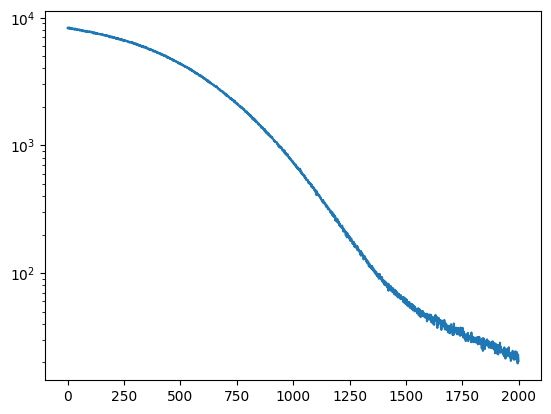

In [25]:
plt.plot(losses)
plt.yscale("log")

In [10]:
gen_datas[0](jr.PRNGKey(0))

TypeError: 'int' object is not subscriptable

In [17]:
y[0]

Array([62], dtype=int32)